# Deep Learning Applications on EEG Signal Classification - Part 2

This part uses: 
- LSTM
- SVM
- Stacking
- Bagging

In [1]:
import pandas as pd
import os
import torch
import torch.nn as nn
import numpy as np


### Data Import

In [4]:

li = []
subjects = ["101.csv", "103.csv", "104.csv", "106.csv", "107.csv", "108.csv", "110.csv", "111.csv", "112.csv", "113.csv", "114.csv", "115.csv", "116.csv", "117.csv", "120.csv", "121.csv"]

for subject in subjects:
    df = pd.read_csv(subject, index_col=None, header=0)
    df['source'] = subject
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)



### 2. Data Exploration

In [5]:
df.head()

,channel_0_bin_0,channel_0_bin_1,channel_0_bin_2,channel_0_bin_3,channel_0_bin_4,channel_0_bin_5,channel_0_bin_6,channel_0_bin_7,channel_0_bin_8,channel_0_bin_9,...,channel_62_bin_6,channel_62_bin_7,channel_62_bin_8,channel_62_bin_9,channel_62_bin_10,channel_62_bin_11,channel_62_bin_12,channel_62_bin_13,result,source
0,2.176302,1.329658,0.829029,0.422999,0.215372,-0.278760,-0.460838,-0.562172,-0.584190,-0.699067,...,0.090683,-0.477405,-0.536059,-0.407767,-0.883532,-0.899170,-1.366808,-1.068980,-1,101.csv
1,2.074731,1.357614,0.907242,0.555199,-0.025510,-0.063800,-0.452389,-0.831895,-0.382434,-0.537716,...,0.088640,-0.447769,-0.345921,-0.461127,-0.601698,-0.964705,-1.248151,-1.071582,-1,101.csv
2,2.148281,1.472900,0.819668,0.387937,0.042995,0.029065,-0.505677,-0.648507,-0.498352,-0.645946,...,0.141754,-0.384420,-0.132046,-0.482288,-0.634268,-1.014824,-1.079052,-1.037410,-1,101.csv
3,2.298024,1.186115,0.940728,0.489109,0.113401,-0.052762,-0.479819,-0.412117,-0.775456,-0.398172,...,0.167400,-0.377004,-0.238230,-0.658857,-0.404948,-0.816655,-1.393657,-0.934989,-1,101.csv
4,2.244293,1.339643,0.834039,0.410846,0.169085,-0.160501,-0.463411,-0.349170,-0.655427,-0.741936,...,0.113343,-0.463476,-0.640948,-0.352614,-0.497145,-0.674318,-1.700601,-0.967857,-1,101.csv


In [6]:
df.describe()

,channel_0_bin_0,channel_0_bin_1,channel_0_bin_2,channel_0_bin_3,channel_0_bin_4,channel_0_bin_5,channel_0_bin_6,channel_0_bin_7,channel_0_bin_8,channel_0_bin_9,...,channel_62_bin_5,channel_62_bin_6,channel_62_bin_7,channel_62_bin_8,channel_62_bin_9,channel_62_bin_10,channel_62_bin_11,channel_62_bin_12,channel_62_bin_13,result
count,31680.000000,31680.000000,31680.000000,31680.000000,31680.000000,31680.000000,31680.000000,31680.000000,31680.000000,31680.000000,...,31680.000000,31680.000000,31680.000000,31680.000000,31680.000000,31680.000000,31680.000000,31680.000000,31680.000000,31680.000000
mean,1.273012,0.520738,0.081071,-0.207352,-0.440243,-0.598354,-0.701046,-0.748926,-0.793480,-0.811981,...,-0.231564,-0.422017,-0.516973,-0.619850,-0.684671,-0.799241,-0.898740,-0.978177,-1.027025,0.000000
std,0.874100,0.812186,0.759913,0.684561,0.654925,0.625814,0.623390,0.609996,0.621388,0.622234,...,0.755016,0.745375,0.715418,0.707550,0.686621,0.688550,0.678001,0.683719,0.671695,1.000016
min,-1.652371,-1.912638,-2.246505,-2.564644,-2.368635,-2.486343,-2.959693,-2.897042,-2.936598,-3.137918,...,-2.141806,-2.464195,-2.435467,-2.548294,-2.766660,-2.825989,-2.970270,-3.097534,-2.969125,-1.000000
25%,0.542709,-0.168075,-0.520852,-0.723214,-0.922391,-1.053100,-1.149500,-1.178239,-1.229557,-1.234573,...,-0.625834,-0.796519,-0.869812,-0.981457,-1.030367,-1.160814,-1.251067,-1.347351,-1.390673,-1.000000
50%,1.221550,0.400631,-0.074348,-0.369765,-0.589855,-0.747807,-0.832838,-0.873947,-0.923210,-0.934821,...,-0.293972,-0.482428,-0.576222,-0.693018,-0.763743,-0.884439,-0.990618,-1.081601,-1.137836,0.000000
75%,2.048612,1.239936,0.730001,0.336021,0.062930,-0.143958,-0.250260,-0.335477,-0.432419,-0.521916,...,-0.031409,-0.230502,-0.344929,-0.442978,-0.525396,-0.617191,-0.739975,-0.799587,-0.864511,1.000000
max,3.381322,2.939025,2.998891,2.879224,2.749595,2.739217,2.618580,2.609443,2.519128,2.494374,...,2.940534,2.737596,2.527629,2.403201,2.240828,2.136532,1.964063,1.961432,1.785517,1.000000


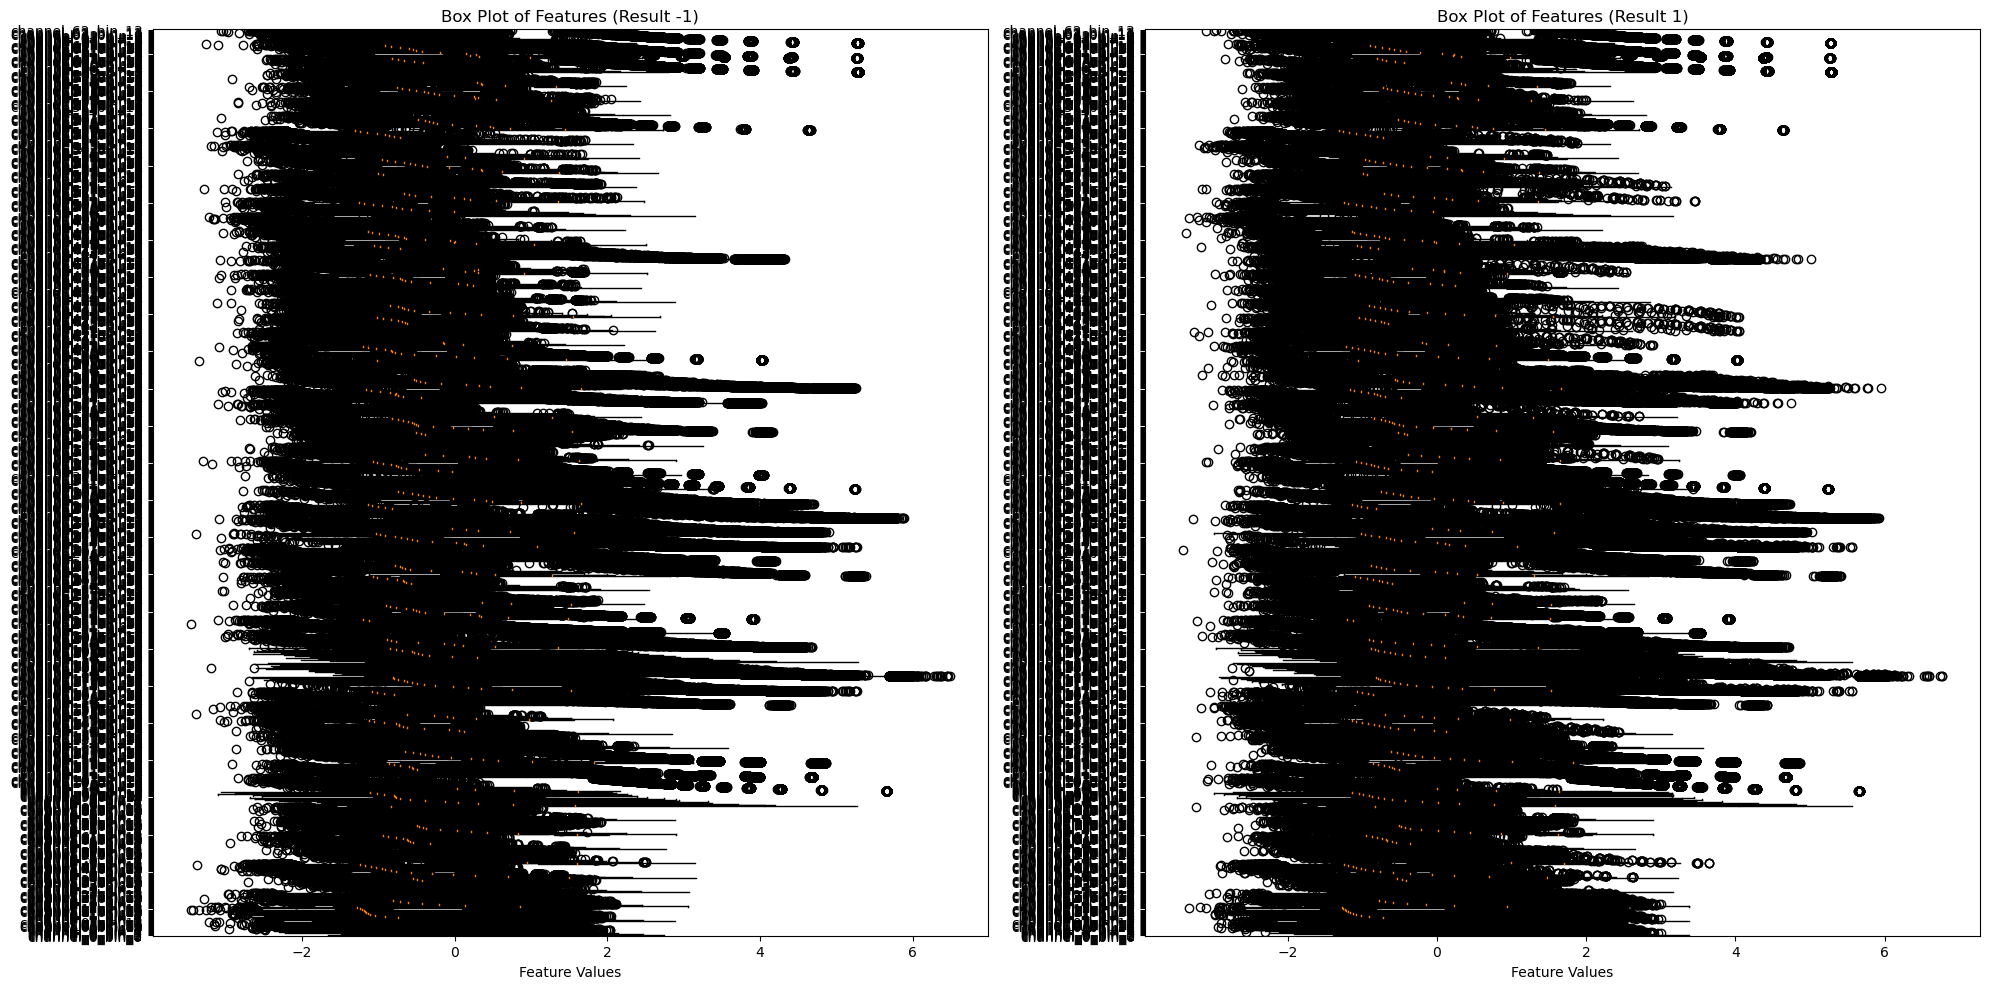

In [7]:
import matplotlib.pyplot as plt
# Prepare data for boxplot
features = df.drop(columns=['result','source'])  # Drop the 'result' column
data_negative = features[df['result'] == -1]
data_positive = features[df['result'] == 1]

# Create a box and whisker plot for each feature
plt.figure(figsize=(20, 10))

# Boxplot for negative results
plt.subplot(1, 2, 1)
plt.boxplot(data_negative.values, vert=False, patch_artist=True)
plt.title('Box Plot of Features (Result -1)')
plt.xlabel('Feature Values')
plt.yticks(range(1, len(features.columns) + 1), features.columns)

# Boxplot for positive results
plt.subplot(1, 2, 2)
plt.boxplot(data_positive.values, vert=False, patch_artist=True)
plt.title('Box Plot of Features (Result 1)')
plt.xlabel('Feature Values')
plt.yticks(range(1, len(features.columns) + 1), features.columns)

plt.tight_layout()
plt.show()


### 3. Data Preprocessing

In [8]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing

X = df.drop(columns=["result", "source"])
y = df["result"]
sources = df["source"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
source_train = sources[X_train.index]
source_test = sources[X_test.index]

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = preprocessing.MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
print(y_train.value_counts())
print(y_test.value_counts())

result
-1    12674
 1    12670
Name: count, dtype: int64
result
 1    3170
-1    3166
Name: count, dtype: int64


### LSTM model

In [15]:
#LSTM

import numpy as np
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

X_train_array = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_array = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])


model_lstm = Sequential()
model_lstm.add(LSTM(50, input_shape=(1, X_train_array.shape[2])))
model_lstm.add(Dense(1, activation='tanh'))

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_lstm.fit(X_train_array, y_train, epochs=10, batch_size=32, validation_split=0.2)

y_pred_prob_lstm = model_lstm.predict(X_test_array)
y_pred_lstm = np.round(y_pred_prob_lstm).flatten()

accuracy_lstm = accuracy_score(y_test, y_pred_lstm)
print(f'LSTM Model Accuracy: {accuracy_lstm}')


Epoch 1/10
634/634 [==============================] - 2s 2ms/step - loss: -0.0125 - accuracy: 0.0000e+00 - val_loss: 0.0456 - val_accuracy: 0.0000e+00
Epoch 2/10
634/634 [==============================] - 1s 1ms/step - loss: -0.0145 - accuracy: 0.0000e+00 - val_loss: 0.0456 - val_accuracy: 0.0000e+00
Epoch 3/10
634/634 [==============================] - 1s 1ms/step - loss: -0.0145 - accuracy: 0.0000e+00 - val_loss: 0.0456 - val_accuracy: 0.0000e+00
Epoch 4/10
634/634 [==============================] - 1s 1ms/step - loss: -0.0145 - accuracy: 0.0000e+00 - val_loss: 0.0456 - val_accuracy: 0.0000e+00
Epoch 5/10
634/634 [==============================] - 1s 1ms/step - loss: -0.0145 - accuracy: 0.0000e+00 - val_loss: 0.0456 - val_accuracy: 0.0000e+00
Epoch 6/10
634/634 [==============================] - 1s 1ms/step - loss: -0.0145 - accuracy: 0.0000e+00 - val_loss: 0.0456 - val_accuracy: 0.0000e+00
Epoch 7/10
634/634 [==============================] - 1s 1ms/step - loss: -0.0145 - accuracy: 

### SVM model

In [48]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import time

start_time = time.time()

svm_model = SVC(kernel='linear') 
svm_model.fit(X_train_svm, y_train)


training_time = time.time() - start_time


y_pred_svm = svm_model.predict(X_test_svm)


accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f'SVM Model Accuracy: {accuracy_svm}')

print(f'Training Time: {training_time} seconds')


SVM Model Accuracy: 0.7807765151515151
Training Time: 390.52634382247925 seconds


#### This uses n_iter=10 for Randomized Search so that it won't take that long

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'C': [0.1, 1],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1],
    'degree': [2]
}

svm_model = SVC()
random_search = RandomizedSearchCV(estimator=svm_model, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy')
random_search.fit(X_train_svm, y_train)

best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

best_svm_model = random_search.best_estimator_
best_svm_model.fit(X_train_svm, y_train)

# Predictions
y_pred_svm = best_svm_model.predict(X_test_svm)

# Evaluate the model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("SVM Model Accuracy:", accuracy_svm)


### Plot for SVM model

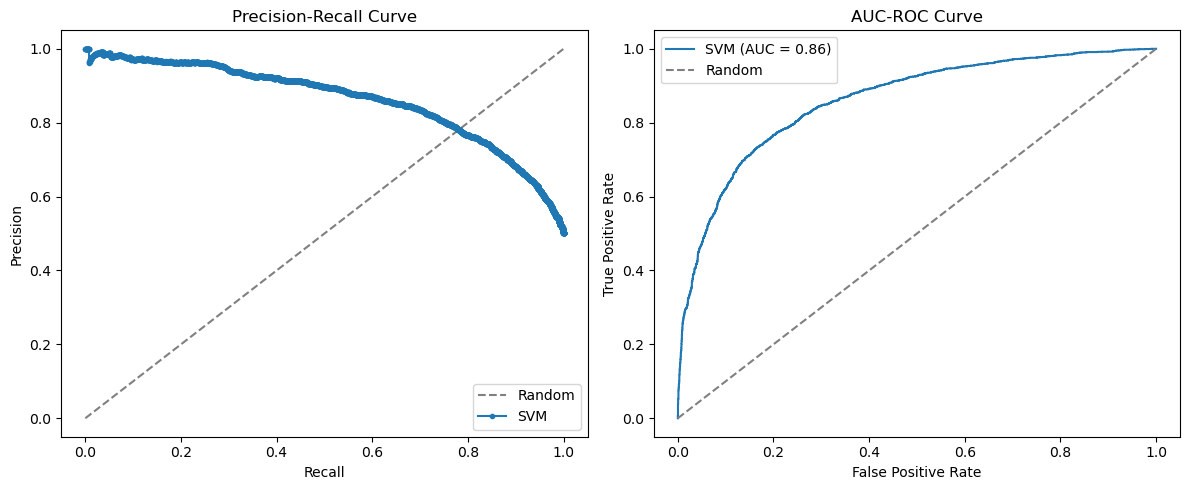

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve


# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, svm_model.decision_function(X_test_svm))

# AUC-ROC Curve
fpr, tpr, _ = roc_curve(y_test, svm_model.decision_function(X_test_svm))
roc_auc = roc_auc_score(y_test, svm_model.decision_function(X_test_svm))

# Plotting
plt.figure(figsize=(12, 5))

# Accuracy, Precision, Recall Plot
plt.subplot(1, 2, 1)
plt.plot([0, 1], [0, 1], linestyle='--', label='Random', color='gray')
plt.plot(recall, precision, marker='.', label='SVM')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

# AUC-ROC Curve Plot
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, label=f'SVM (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


### Stacking

In [28]:
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import time

# Assuming X_train, X_test, y_train, y_test are your data
dt_clf = DecisionTreeClassifier(random_state=42)
rf_clf = RandomForestClassifier(random_state=42)
lr_clf = LogisticRegression(random_state=42, max_iter=1000)

# Stacking Classifier
stacking_clf = StackingClassifier(estimators=[('dt', dt_clf), ('rf', rf_clf), ('lr', lr_clf)], final_estimator=LogisticRegression())

start_time = time.time()
stacking_clf.fit(X_train, y_train)
training_time = time.time() - start_time

start_time = time.time()
accuracy = stacking_clf.score(X_test, y_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

testing_time = time.time() - start_time


# Evaluate the model
print("Stacking Accuracy:", accuracy)
print("Training Time:", training_time, "seconds")
print("Testing Time:", testing_time, "seconds")


Stacking Accuracy: 0.9608585858585859
Training Time: 595.9188711643219 seconds
Testing Time: 0.1745760440826416 seconds


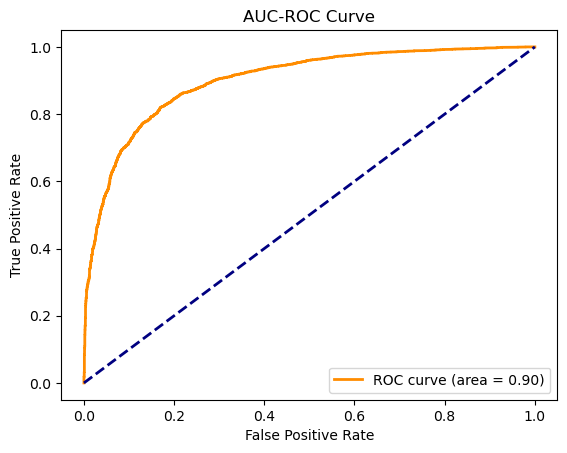

In [47]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities
y_scores = stacking_clf.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve')
plt.legend(loc='lower right')
plt.show()


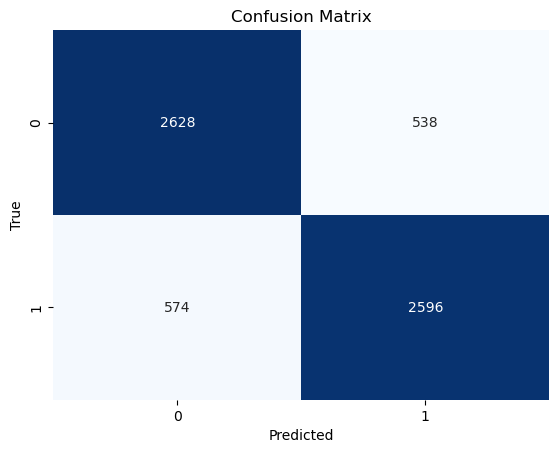

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predicted labels
y_pred = stacking_clf.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


### Decision Tree + Logistic Regression w/ final estimator  = Logistic Regression


In [42]:
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import time

# Assuming X_train, X_test, y_train, y_test are your data
dt_clf = DecisionTreeClassifier(random_state=42)
lr_clf = LogisticRegression(random_state=42, max_iter=200)

# Stacking Classifier
stacking_clf = StackingClassifier(estimators=[('dt', dt_clf), ('lr', lr_clf)], final_estimator=LogisticRegression())

start_time = time.time()
stacking_clf.fit(X_train, y_train)
training_time = time.time() - start_time

start_time = time.time()
accuracy = stacking_clf.score(X_test, y_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

testing_time = time.time() - start_time


# Evaluate the model
print("Stacking Accuracy:", accuracy)
print("Training Time:", training_time, "seconds")
print("Testing Time:", testing_time, "seconds")


/Users/blackyperng/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/blackyperng/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

Stacking Accuracy: 0.8244949494949495
Training Time: 181.13887310028076 seconds
Testing Time: 0.024974822998046875 seconds


/Users/blackyperng/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Decision Tree + Logistic Regression w/ final estimator  = Decision Tree

In [41]:
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import time

# Assuming X_train, X_test, y_train, y_test are your data
dt_clf = DecisionTreeClassifier(random_state=42)
lr_clf = LogisticRegression(random_state=42, max_iter=200)

# Stacking Classifier
stacking_clf = StackingClassifier(estimators=[('dt', dt_clf), ('lr', lr_clf)], final_estimator=DecisionTreeClassifier())

start_time = time.time()
stacking_clf.fit(X_train, y_train)
training_time = time.time() - start_time

start_time = time.time()
accuracy = stacking_clf.score(X_test, y_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

testing_time = time.time() - start_time


# Evaluate the model
print("Stacking Accuracy:", accuracy)
print("Training Time:", training_time, "seconds")
print("Testing Time:", testing_time, "seconds")


/Users/blackyperng/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/blackyperng/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

Stacking Accuracy: 0.7394255050505051
Training Time: 182.05862879753113 seconds
Testing Time: 0.14509797096252441 seconds


### Bagging


In [21]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
base_model = DecisionTreeClassifier(random_state=42)
n_estimators = 10

bagging_clf = BaggingClassifier(base_model, n_estimators=n_estimators, random_state=42)
bagging_clf.fit(X_train, y_train)

y_pred = bagging_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f'Bagging Classifier Accuracy: {accuracy}')
print(f'Bagging Classifier Precision: {precision}')
print(f'Bagging Classifier Recall: {recall}')


Bagging Classifier Accuracy: 0.8710542929292929
Bagging Classifier Precision: 0.9011251278554381
Bagging Classifier Recall: 0.8337539432176656
